# Fingerprints

In [7]:
import numpy as np
import matplotlib as mpl; import matplotlib.pyplot as plt
%matplotlib inline
import os; import pickle
#import sympy
#import scipy
#from scipy import special

## No1 SIL 18

In [91]:
all_spins = 2*np.pi*1000 * np.genfromtxt('complete_lattice.csv', delimiter=',') # imported in Hz
all_spins[:,1] = np.abs(all_spins[:,1])

In [92]:
# taken from /Users/juan/Downloads/fitting_fingerprints/fitting_fingerprints/hyperfine_params.py
hyperfine_params = {} # I'm assuming that these come in Hz
hyperfine_params['C1']  = {'par' : -36.0e3, 'perp':25.0e3}
hyperfine_params['C2']  = {'par' : 21.2e3, 'perp':43.0e3}
hyperfine_params['C3']  = {'par' : -11.0e3, 'perp':55.0e3}
hyperfine_params['C4']  = {'par' : 8.1e3, 'perp':21.0e3}
hyperfine_params['C5']  = {'par' : 24.7e3, 'perp':26.0e3}
hyperfine_params['C6']  = {'par' : -48.7e3, 'perp':12.0e3}
hyperfine_params['C7']  = {'par' : 14.5e3, 'perp':11.0e3}
# hyperfine_params['C8']  = {'par' : -20.5e3, 'perp':21.0e3}
hyperfine_params['C8']  = {'par' : 7.32e3, 'perp':5.0e3}

In [93]:
par_params = []
perp_params = []
for llave in hyperfine_params.keys(): # convert to rad/s
    par_params.append(2.*np.pi*hyperfine_params[llave]['par'])
    perp_params.append(2.*np.pi*hyperfine_params[llave]['perp'])

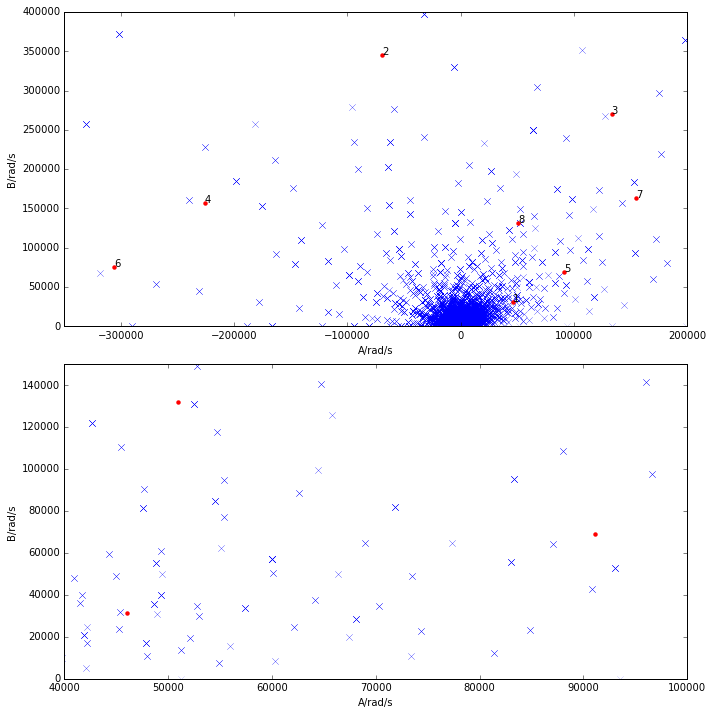

In [109]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.scatter(all_spins[:,0],all_spins[:,1],marker='x',s=40,lw=0.1)
plt.scatter(par_params,perp_params,c='r',lw=0)
plt.xlim(-350000,200000)
plt.ylim(0,400000)
plt.xlabel('A/rad/s')
plt.ylabel('B/rad/s')
for i in range(len(par_params)):
    plt.text(par_params[i],perp_params[i],str(i+1))
plt.subplot(2,1,2)
plt.scatter(all_spins[:,0],all_spins[:,1],marker='x',s=40,lw=0.1)
plt.scatter(par_params,perp_params,c='r',lw=0)
plt.xlim(40000,100000)
plt.ylim(0,150000)
plt.xlabel('A/rad/s')
plt.ylabel('B/rad/s')
plt.tight_layout()
plt.show()

In [119]:
sil18={}
magic_Ns=[4,8,16,32,64]
for num in magic_Ns:
    sil18[num] = np.transpose(np.loadtxt('/Users/juan/Downloads/fitting_fingerprints/sil18_fingerprint_ms_plus_N'+str(num)+'.txt'))

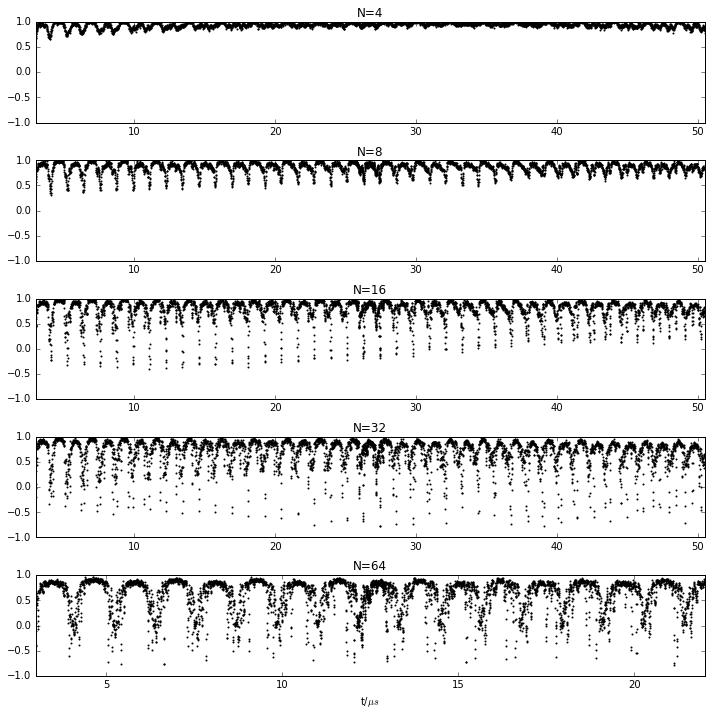

In [130]:
plt.figure(figsize=(10,10))
for counter in range(len(magic_Ns)):
    plt.subplot(len(magic_Ns),1,counter+1)
    this_magic_N=magic_Ns[counter]
    plt.scatter(sil18[this_magic_N][:,0],sil18[this_magic_N][:,1],s=1)
    plt.xlim(min(sil18[this_magic_N][:,0]),max(sil18[this_magic_N][:,0]))
    plt.ylim(-1,1)
    plt.title('N='+str(this_magic_N))
plt.xlabel('t/$\mu s$')
plt.tight_layout()
plt.show()

## Try the bootstrap fit

### N = 64

In [137]:
%load_ext autoreload
%autoreload 1
import numpy as np
import matplotlib.pyplot as plt
import time
import os,sys,inspect
import pickle
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
%aimport analysis
%aimport learning
%aimport NV_generator

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [138]:
B_field = 0.0403555 # Teslas
gam_c = 67.262 * 10 ** 6 # Gyromagnetic ratio for a single c13 nucleus in rad s-1 T-1
ms = 1
omega_larmor = -1. * ms * gam_c * B_field

In [139]:
def closeness(x,y):
    return sum(x*y)/(np.sqrt(sum(x**2))*np.sqrt(sum(y**2)))

In [147]:
sample = sil18[64][:,1]
tau_times = sil18[64][:,0]*10**(-6)

In [149]:
# In here the bootstrap is applied.
# Each round takes about 80s.
#%%time
current_fit = np.ones(len(sample))
fitted_As=[]
fitted_Bs=[]
remaining_spins = np.copy(all_spins)
counter_3 = 0
path_followed = []
best_resemblance = 0.
for counter_1 in range(20):
    closenesses=[]
    print("round "+str(counter_1))
    for counter_2 in range(len(remaining_spins)):
        AB = remaining_spins[counter_2] # Select the spin to be considered.
#         if (counter_2 % 200 == 0 and counter_1 > 0) or (counter_2 % 1000 == 0 and counter_1 == 0):
#             frac = int(float(counter_2)/len(remaining_spins)*100.)
#             print(frac),
        ansatz = current_fit * analysis.calc_M_single(AB[0],AB[1],64, omega_larmor,tau_times) # calculate the signal that would result if the new spin was added to it
        closenesses.append(closeness(ansatz, sample)) # append the resulting closeness to the list that stores them all
    max_closenesses_index = np.argmax(closenesses) # Find the index for the spin that gave the greater similarity
    best_resemblance = closenesses[max_closenesses_index]
    if closenesses[max_closenesses_index] >= best_resemblance:
        print('Going uphill')
    else:
        print('Going downhill')
    best_A = remaining_spins[max_closenesses_index][0]
    best_B = remaining_spins[max_closenesses_index][1]
    print("best = "+str(best_resemblance))
    path_followed.append(best_resemblance) # Append the best closeness
    fitted_As.append(remaining_spins[max_closenesses_index][0]) # Append the best A
    fitted_Bs.append(remaining_spins[max_closenesses_index][1]) # Append the best B
    current_fit = current_fit * analysis.calc_M_single(best_A,best_B,64, omega_larmor,tau_times) # Calculate the updated fit for M
    if False and (counter_1 == 0): # Enable this to eliminate most spins on end of firs iteration. This was not enabled for the plot showed in the report.
        remaining_spins = remaining_spins[np.argsort(closenesses)[-5000:]]
    else:
        remaining_spins=np.delete(remaining_spins,max_closenesses_index,axis=0) # Eliminate the best spin from the set of possible options.

round 0
Going uphill
best = 0.88639566388
round 1
Going uphill
best = 0.900352896953
round 2
Going uphill
best = 0.912027964038
round 3
Going uphill
best = 0.920370088124
round 4
Going uphill
best = 0.927510740301
round 5
Going uphill
best = 0.933296188425
round 6
Going uphill
best = 0.937083974706
round 7
Going uphill
best = 0.94070040039
round 8
Going uphill
best = 0.94331887148
round 9
Going uphill
best = 0.945156533952
round 10
Going uphill
best = 0.946808357608
round 11
Going uphill
best = 0.94833892325
round 12
Going uphill
best = 0.949580698916
round 13
Going uphill
best = 0.950747615383
round 14
Going uphill
best = 0.951910732193
round 15
Going uphill
best = 0.952991808083
round 16
Going uphill
best = 0.953822586097
round 17
Going uphill
best = 0.954562402668
round 18
Going uphill
best = 0.955307373738
round 19
Going uphill
best = 0.956039585092


In [ ]:
pickle.dump({'tauN':64,fitted_As':fitted_As,'fitted_Bs':fitted_Bs})

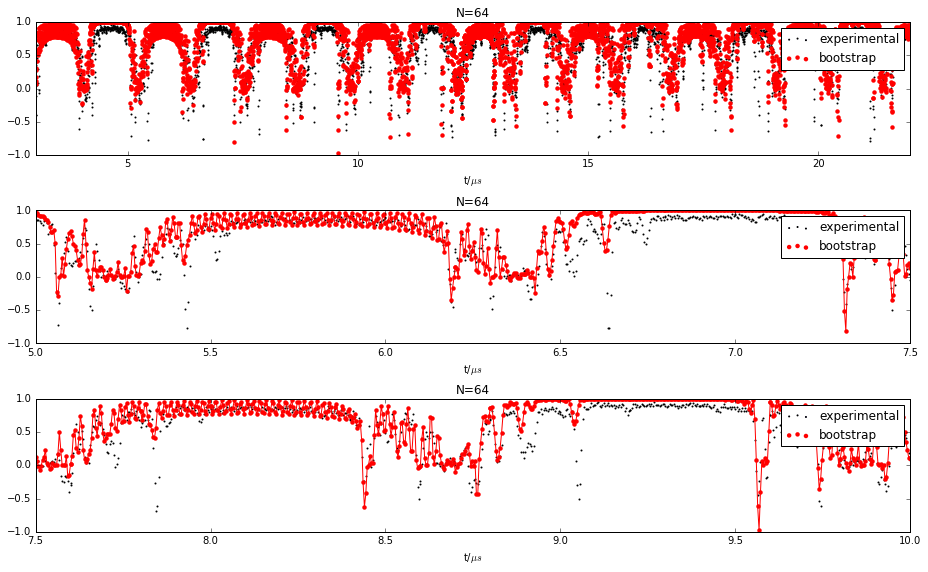

In [182]:
plt.figure(figsize=(13,8))
plt.subplot(3,1,1)
plt.scatter(sil18[64][:,0],sil18[64][:,1],s=1,label='experimental')
#plt.plot(sil18[64][:,0],current_fit,'r',label='fit')
plt.scatter(sil18[64][:,0],current_fit,c='r',label='bootstrap',lw=0.)
plt.xlim(min(sil18[64][:,0]),max(sil18[64][:,0]))
plt.ylim(-1,1)
plt.title('N=64')
plt.xlabel('t/$\mu s$')
plt.legend()
plt.subplot(3,1,2)
plt.scatter(sil18[64][:,0],sil18[64][:,1],s=1,label='experimental')
#plt.plot(sil18[64][:,0],current_fit,'r',label='fit')
plt.scatter(sil18[64][:,0],current_fit,c='r',label='bootstrap',lw=0.)
plt.plot(sil18[64][:,0],current_fit,'r')
plt.xlim(5,7.5)
plt.ylim(-1,1)
plt.title('N=64')
plt.xlabel('t/$\mu s$')
plt.legend()
plt.subplot(3,1,3)
plt.scatter(sil18[64][:,0],sil18[64][:,1],s=1,label='experimental')
#plt.plot(sil18[64][:,0],current_fit,'r',label='fit')
plt.scatter(sil18[64][:,0],current_fit,c='r',label='bootstrap',lw=0.)
plt.plot(sil18[64][:,0],current_fit,'r')
plt.xlim(7.5,10)
plt.ylim(-1,1)
plt.title('N=64')
plt.xlabel('t/$\mu s$')
plt.legend()
plt.tight_layout()
plt.show()

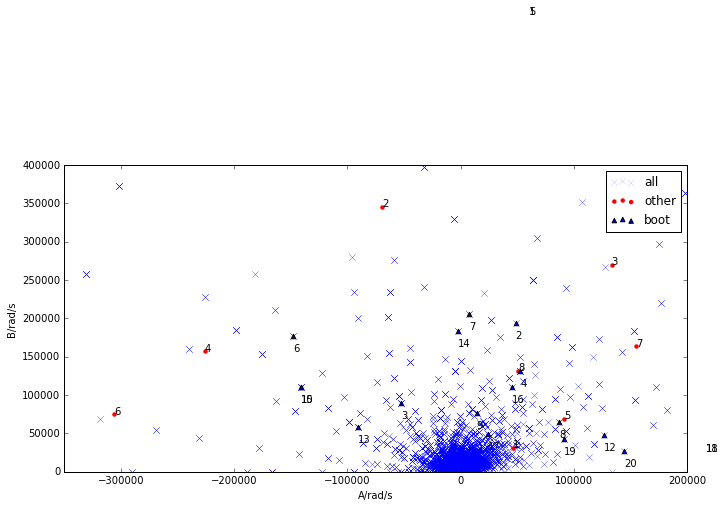

In [194]:
plt.figure(figsize=(10,5))
plt.scatter(all_spins[:,0],all_spins[:,1],marker='x',s=40,lw=0.1,label='all')
plt.scatter(par_params,perp_params,c='r',lw=0,label='other')
plt.scatter(fitted_As,fitted_Bs,marker='^',label='boot')
plt.xlim(-350000,200000)
plt.ylim(0,400000)
plt.xlabel('A/rad/s')
plt.ylabel('B/rad/s')
for i in range(len(par_params)):
    plt.text(par_params[i],perp_params[i],str(i+1))
for i in range(len(fitted_As)):
    plt.text(fitted_As[i],fitted_Bs[i]-20000,str(i+1))
plt.legend()
plt.tight_layout()
plt.show()

### N = 64 (optimized)

In [195]:
%load_ext autoreload
%autoreload 1
import numpy as np
import matplotlib.pyplot as plt
import time
import os,sys,inspect
import pickle
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
%aimport analysis
%aimport learning
%aimport NV_generator

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [196]:
B_field = 0.0403555 # Teslas
gam_c = 67.262 * 10 ** 6 # Gyromagnetic ratio for a single c13 nucleus in rad s-1 T-1
ms = 1
omega_larmor = -1. * ms * gam_c * B_field

In [197]:
def closeness(x,y):
    return sum(x*y)/(np.sqrt(sum(x**2))*np.sqrt(sum(y**2)))

In [147]:
sample = sil18[64][:,1]
tau_times = sil18[64][:,0]*10**(-6)

In [214]:
all_single_Ms = []
for counter_2 in range(len(all_spins)):
    AB = all_spins[counter_2] # Select the spin to be considered.
    all_single_Ms.append(analysis.calc_M_single(AB[0],AB[1],64, omega_larmor,tau_times)) # calculate the signal that would result if the new spin was added to it
    #closenesses.append(closeness(ansatz, sample)) # append the resulting closeness to the list that stores them all

In [211]:
9.16 * 10**(-3) * len(all_spins)

307.15312

In [149]:
# In here the bootstrap is applied.
# Each round takes about 80s.
#%%time
current_fit = np.ones(len(sample))
fitted_As=[]
fitted_Bs=[]
remaining_spins = np.copy(all_spins)
counter_3 = 0
path_followed = []
best_resemblance = 0.
for counter_1 in range(20):
    closenesses=[]
    print("round "+str(counter_1))
    for counter_2 in range(len(remaining_spins)):
        AB = remaining_spins[counter_2] # Select the spin to be considered.
#         if (counter_2 % 200 == 0 and counter_1 > 0) or (counter_2 % 1000 == 0 and counter_1 == 0):
#             frac = int(float(counter_2)/len(remaining_spins)*100.)
#             print(frac),
        ansatz = current_fit * analysis.calc_M_single(AB[0],AB[1],64, omega_larmor,tau_times) # calculate the signal that would result if the new spin was added to it
        closenesses.append(closeness(ansatz, sample)) # append the resulting closeness to the list that stores them all
    max_closenesses_index = np.argmax(closenesses) # Find the index for the spin that gave the greater similarity
    best_resemblance = closenesses[max_closenesses_index]
    if closenesses[max_closenesses_index] >= best_resemblance:
        print('Going uphill')
    else:
        print('Going downhill')
    best_A = remaining_spins[max_closenesses_index][0]
    best_B = remaining_spins[max_closenesses_index][1]
    print("best = "+str(best_resemblance))
    path_followed.append(best_resemblance) # Append the best closeness
    fitted_As.append(remaining_spins[max_closenesses_index][0]) # Append the best A
    fitted_Bs.append(remaining_spins[max_closenesses_index][1]) # Append the best B
    current_fit = current_fit * analysis.calc_M_single(best_A,best_B,64, omega_larmor,tau_times) # Calculate the updated fit for M
    if False and (counter_1 == 0): # Enable this to eliminate most spins on end of firs iteration. This was not enabled for the plot showed in the report.
        remaining_spins = remaining_spins[np.argsort(closenesses)[-5000:]]
    else:
        remaining_spins=np.delete(remaining_spins,max_closenesses_index,axis=0) # Eliminate the best spin from the set of possible options.

round 0
Going uphill
best = 0.88639566388
round 1
Going uphill
best = 0.900352896953
round 2
Going uphill
best = 0.912027964038
round 3
Going uphill
best = 0.920370088124
round 4
Going uphill
best = 0.927510740301
round 5
Going uphill
best = 0.933296188425
round 6
Going uphill
best = 0.937083974706
round 7
Going uphill
best = 0.94070040039
round 8
Going uphill
best = 0.94331887148
round 9
Going uphill
best = 0.945156533952
round 10
Going uphill
best = 0.946808357608
round 11
Going uphill
best = 0.94833892325
round 12
Going uphill
best = 0.949580698916
round 13
Going uphill
best = 0.950747615383
round 14
Going uphill
best = 0.951910732193
round 15
Going uphill
best = 0.952991808083
round 16
Going uphill
best = 0.953822586097
round 17
Going uphill
best = 0.954562402668
round 18
Going uphill
best = 0.955307373738
round 19
Going uphill
best = 0.956039585092


In [ ]:
pickle.dump({'tauN':64,fitted_As':fitted_As,'fitted_Bs':fitted_Bs})

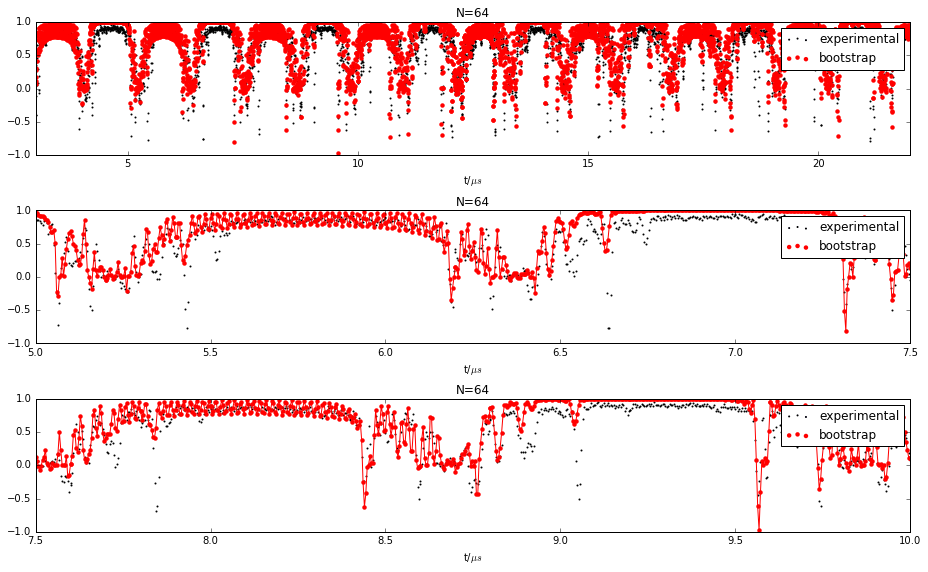

In [182]:
plt.figure(figsize=(13,8))
plt.subplot(3,1,1)
plt.scatter(sil18[64][:,0],sil18[64][:,1],s=1,label='experimental')
#plt.plot(sil18[64][:,0],current_fit,'r',label='fit')
plt.scatter(sil18[64][:,0],current_fit,c='r',label='bootstrap',lw=0.)
plt.xlim(min(sil18[64][:,0]),max(sil18[64][:,0]))
plt.ylim(-1,1)
plt.title('N=64')
plt.xlabel('t/$\mu s$')
plt.legend()
plt.subplot(3,1,2)
plt.scatter(sil18[64][:,0],sil18[64][:,1],s=1,label='experimental')
#plt.plot(sil18[64][:,0],current_fit,'r',label='fit')
plt.scatter(sil18[64][:,0],current_fit,c='r',label='bootstrap',lw=0.)
plt.plot(sil18[64][:,0],current_fit,'r')
plt.xlim(5,7.5)
plt.ylim(-1,1)
plt.title('N=64')
plt.xlabel('t/$\mu s$')
plt.legend()
plt.subplot(3,1,3)
plt.scatter(sil18[64][:,0],sil18[64][:,1],s=1,label='experimental')
#plt.plot(sil18[64][:,0],current_fit,'r',label='fit')
plt.scatter(sil18[64][:,0],current_fit,c='r',label='bootstrap',lw=0.)
plt.plot(sil18[64][:,0],current_fit,'r')
plt.xlim(7.5,10)
plt.ylim(-1,1)
plt.title('N=64')
plt.xlabel('t/$\mu s$')
plt.legend()
plt.tight_layout()
plt.show()

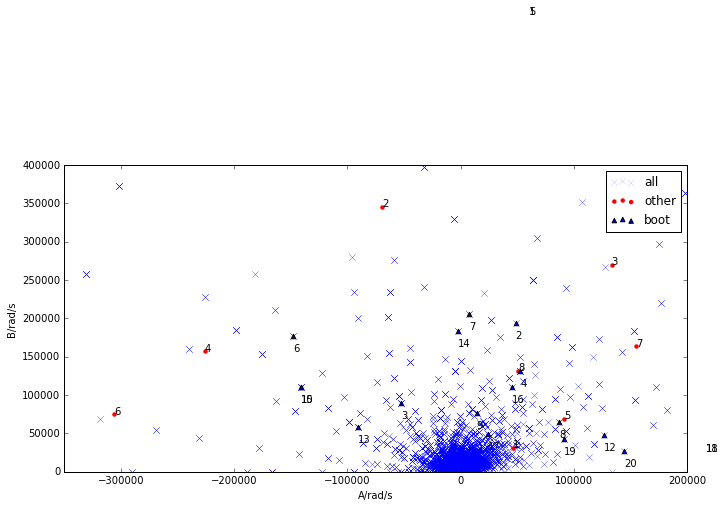

In [194]:
plt.figure(figsize=(10,5))
plt.scatter(all_spins[:,0],all_spins[:,1],marker='x',s=40,lw=0.1,label='all')
plt.scatter(par_params,perp_params,c='r',lw=0,label='other')
plt.scatter(fitted_As,fitted_Bs,marker='^',label='boot')
plt.xlim(-350000,200000)
plt.ylim(0,400000)
plt.xlabel('A/rad/s')
plt.ylabel('B/rad/s')
for i in range(len(par_params)):
    plt.text(par_params[i],perp_params[i],str(i+1))
for i in range(len(fitted_As)):
    plt.text(fitted_As[i],fitted_Bs[i]-20000,str(i+1))
plt.legend()
plt.tight_layout()
plt.show()